# IAU Project - Phase 1 (EDA)

Dataset: 049

Authors: **Lubomir Dlhy** (50%) & **Anastasiia Hrytsyna** (50%)

In [2]:
# Initialization
import pylab as py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from datetime import date
import warnings
warnings.filterwarnings("ignore")

### Loading the dataset

In [3]:
# Initialization of laboratory data
labor_filename = "data/labor.csv"
df_labor = pd.read_csv(labor_filename, sep='\t', index_col=0)
df_labor.head()

,er-cv,name,ssn,weight,relationship,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,erytrocyty,etytr,hemoglobin,hbver,smoker
0,78.56699,Anthony Jimenez,333-64-1123,15.76110,divoced,1.65351,5.63528,8.01736,0.0,65.02434,47.76901,7.83628,4.86947,6.99561,4.79938,6.49599,yes
1,74.30939,Katrina Henry,070-27-2362,29.68284,married,4.24185,6.44273,5.30115,1.0,33.94714,83.31624,5.66226,7.57419,6.98433,6.17203,5.51031,yes
2,74.76469,James Wright,780-96-6961,72.35611,single,1.37327,6.94290,6.21616,0.0,48.12521,16.87901,3.92559,5.05230,8.90033,3.70336,7.27439,no
3,65.94408,Mikayla Martinez,075-19-9728,92.35049,widowed,4.29869,5.54264,7.28879,1.0,41.49208,13.15951,4.55405,7.97588,7.38037,8.77214,6.99109,yes
4,52.15382,Elizabeth Ford,158-72-8664,82.79599,separated,2.24222,6.24041,6.18476,0.0,64.99849,83.37123,5.72029,5.24884,5.34311,5.72834,6.01808,no


In [4]:
# Initialization of profiles data
profile_filename = "data/profiles.csv"
df_profile = pd.read_csv(profile_filename, sep='\t', index_col=0)
df_profile.head()

,birthdate,current_location,blood_group,name,address,company,ssn,sex,race
0,2014/07/01,"(Decimal('-82.621114'), Decimal('23.518377'))",B-,Sean Spencer,"95075 Schwartz Villages\nNorth Gregory, CO 33865",Morales-Brooks,055-30-3156,M,White
1,"11/13/1944, 00:00:00","(Decimal('-20.9039775'), Decimal('-40.623255'))",AB-,Ashley Park,"396 Mary Run Apt. 286\nReedbury, MS 60715",Lawson Group,729-30-0367,F,White
2,1914-12-05,"(Decimal('25.127018'), Decimal('-104.955939'))",A-,Deborah Santiago,"936 Ebony Mount Apt. 735\nMarkbury, ME 18330",Serrano PLC,511-45-0389,F,Black
3,"07/07/2011, 00:00:00","(Decimal('38.9083155'), Decimal('-47.338828'))",B+,Janet Harmon,"2184 Jacob Springs Suite 501\nPort Kevin, IA 5...","Sandoval, Hammond and Stephens",539-72-3463,F,White
4,1968/05/17,"(Decimal('-71.8557275'), Decimal('-98.202543'))",B-,William Brown,"0151 Diaz Brooks\nNorth Christopherland, MT 71895","Williams, Williams and Allen",150-69-6532,M,Black


In [5]:
# Setting color map to the future plots
sns.set_palette('twilight')

### Identification of the problems in dataset with proposed solution

First of all we decided to clean our data. Thus we have changed the next info:

- from both dataframes we removed duplicates (~100 records) and NA values (~300 records)
- one and only attribute 'weight' was negative (234 records); in real life it is impossible, so we just changed it to its absolute value
- we checked for unique values in categorical attributes and fixed grammar mistakes
    - we changed 'divoced' to 'divorced' status relationship and convert 'nop' to 'single' (cauze, basically, it is the same term) 
    - we changed the 'race' attribute so that it does not have any grammar mistakes (blsck, black, ...)
- some attributes used string encoding for categorical data which is not useful:
    - we encoded 'smoker' attribute to 1 (from 'yes' or 'Y') or 0 (from 'no' or 'N')
- we also checked if there are whitespaces in the 'name' attribute, there were no problems
- in both dataframes we corrected the datatypes of major part of the attributes:
    - 'indicator' to int
    - 'relationship' to category
    - 'blood_group' to category
    - 'sex' to category
    - 'race' to category
    - 'birthdate' to datetime
- we also decided to count the age of each person, as it is important attribute to our survey (from the attribute birthdate)
- at the end we decided to delete unnecessary attributes such as 'name', 'address', 'company', 'current_location'

#### CLEANING LABOR DATA

In [6]:
# Remove unnecessary duplicates
print(f"Before removing: {df_labor.shape}")
df_labor = df_labor.drop_duplicates()
print(f"After removing: {df_labor.shape}")

Before removing: (9914, 17)
After removing: (9816, 17)


In [7]:
# Delete incomplete data
df_labor = df_labor.dropna()
print(f"After deleting: {df_labor.shape}")

After deleting: (9503, 17)


In [8]:
# Checking if there are some negative values
df_labor.select_dtypes(include=np.number).lt(0).sum()

er-cv           0
weight        234
alt             0
trombocyty      0
hematokrit      0
indicator       0
ast             0
alp             0
leukocyty       0
erytrocyty      0
etytr           0
hemoglobin      0
hbver           0
dtype: int64

In [9]:
# Correct weight attribute to the positive value and round it
df_labor['weight'] = df_labor['weight'].apply(lambda x: x*(-1) if x < 0 else x)
df_labor['weight'] = df_labor['weight'].round(2)

# Checking weight attribute
print(f"Fresh value: {df_labor['weight'].lt(0).sum()}")

Fresh value: 0


In [10]:
# Correct some small grammar mistakes
df_labor['relationship'] = df_labor['relationship'].replace({'divoced':'divorced'})
df_labor['relationship'] = df_labor['relationship'].replace({'nop':'single'})
print(f"Possible relationship values: {df_labor['relationship'].unique()}")

Possible relationship values: ['divorced' 'married' 'single' 'widowed' 'separated']


In [11]:
# Fitting the info about smoking habits 
print(f"Possible smoker values before cleaning: {df_labor['smoker'].unique()}\n")
df_labor['smoker'] = df_labor['smoker'].replace({"yes":1, 'Y':1, "no":0, 'N':0})
print(f"Possible smoker values after cleaning: {df_labor['smoker'].unique()}")

Possible smoker values before cleaning: ['yes' 'no' 'Y' 'N']

Possible smoker values after cleaning: [1 0]


In [12]:
# Check for leading or trailing whitespaces in name
df_labor[df_labor['name'] != df_labor['name'].str.strip()]

,er-cv,name,ssn,weight,relationship,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,erytrocyty,etytr,hemoglobin,hbver,smoker


In [13]:
# Modify the data types
df_labor = df_labor.astype({'indicator':'int','relationship':'category'})
print(f"Data types of laboratory attributes:\n\n{df_labor.dtypes}")

Data types of laboratory attributes:

er-cv            float64
name              object
ssn               object
weight           float64
relationship    category
alt              float64
trombocyty       float64
hematokrit       float64
indicator          int32
ast              float64
alp              float64
leukocyty        float64
erytrocyty       float64
etytr            float64
hemoglobin       float64
hbver            float64
smoker             int64
dtype: object


In [14]:
# Drop useless data
df_labor = df_labor.drop(columns=['name'])

#### CLEANING PROFILE DATA

In [15]:
# Remove unnecessary duplicates
print(f"Before removing: {df_profile.shape}")
df_profile = df_profile.drop_duplicates()
print(f"After removing: {df_profile.shape}")
print("\nThere were no duplicates")

Before removing: (3184, 9)
After removing: (3184, 9)

There were no duplicates


In [16]:
# Delete incomplete data
df_profile = df_profile.dropna()
print(f"After deleting: {df_profile.shape}")
print("\nThere were no partial data")

After deleting: (3184, 9)

There were no partial data


In [17]:
# Fitting the info 
print(f"Race values before cleaning: {df_profile['race'].unique()}\n")
df_profile['race'] = df_profile['race'].replace({"black":"Black", 'white':"White", "blsck":"Black"})
print(f"Possible race values: {df_profile['race'].unique()}")

Race values before cleaning: ['White' 'Black' 'Hawaiian' 'Asian' 'black' 'white' 'Indian' 'blsck']

Possible race values: ['White' 'Black' 'Hawaiian' 'Asian' 'Indian']


In [18]:
# Modify the data types
df_profile['birthdate'] = pd.to_datetime(df_profile.birthdate)
df_profile = df_profile.astype({'blood_group': 'category','sex': 'category', 'race': 'category'})
print(f"Data types of profile attributes:\n{df_profile.dtypes}")

Data types of profile attributes:
birthdate           datetime64[ns]
current_location            object
blood_group               category
name                        object
address                     object
company                     object
ssn                         object
sex                       category
race                      category
dtype: object


In [19]:
# Drop useless data
df_profile = df_profile.drop(columns=['address','company','current_location','name'])

In [20]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df_profile['age'] = df_profile['birthdate'].apply(calculate_age)
df_profile['age']

0         7
1        77
2       106
3        10
4        53
       ... 
3179     70
3180     22
3181     74
3182     15
3183     63
Name: age, Length: 3184, dtype: int64

#### MERGING ALL DATA

- At the end we merge both dataframes together using the social security number which is unique for each individual

In [21]:
df_merged = pd.merge(df_labor, df_profile, how="inner", on='ssn')

### Basic data description and characteristics

In [22]:
labor_rows, labor_cols = df_labor.shape
profile_rows, profile_cols = df_profile.shape
print(f"Laboratory records: {labor_rows}\nProfile records: {profile_rows}\n")
print(f"Laboratory attributes: {labor_cols}\nProfile attributes: {profile_cols}")

Laboratory records: 9503
Profile records: 3184

Laboratory attributes: 16
Profile attributes: 6


In [23]:
print(f"Data types of laboratory attributes:\n\n{df_labor.dtypes}")

Data types of laboratory attributes:

er-cv            float64
ssn               object
weight           float64
relationship    category
alt              float64
trombocyty       float64
hematokrit       float64
indicator          int32
ast              float64
alp              float64
leukocyty        float64
erytrocyty       float64
etytr            float64
hemoglobin       float64
hbver            float64
smoker             int64
dtype: object


In [24]:
print(f"Data types of profile attributes:\n\n{df_profile.dtypes}")

Data types of profile attributes:

birthdate      datetime64[ns]
blood_group          category
ssn                    object
sex                  category
race                 category
age                     int64
dtype: object


##### Descriptive statistics of main blood attributes

leukocyty & erytrocyty have similar statistics (mean, quantiles, max)

In [25]:
df_labor[["hemoglobin", "trombocyty", "leukocyty", "erytrocyty"]].describe()

,hemoglobin,trombocyty,leukocyty,erytrocyty
count,9503.000000,9503.000000,9503.000000,9503.000000
mean,6.291657,6.276938,5.850759,5.834916
std,1.739024,1.002804,1.616859,1.733794
min,0.390420,2.197430,0.891210,0.000000
25%,5.028130,5.609275,4.688915,4.599305
50%,6.290810,6.271120,5.671610,5.749360
75%,7.549000,6.955620,6.988425,7.060980
max,13.138880,10.134770,11.536010,11.588490


##### Distribution of main personal attributes

- sex is almost equally distributed

- white is dominant in race

- blood groups are similarly distributed (there are rare and common blood groups in real life so data for this attribute might be random)

- single, married & divorced have similar distribution

In [26]:
##### Descriptive statistics of main blood attributes

print(f">> Sex distribution <<\n{df_profile['sex'].value_counts()}")
print(f"\n\n>> Race distribution <<\n{df_profile['race'].value_counts()}")
print(f"\n\n>> Blood_group distribution <<\n{df_profile['blood_group'].value_counts()}")

>> Sex distribution <<
M    1611
F    1573
Name: sex, dtype: int64


>> Race distribution <<
White       1637
Black        900
Asian        348
Hawaiian     161
Indian       138
Name: race, dtype: int64


>> Blood_group distribution <<
AB+    431
O+     402
AB-    401
B+     400
O-     395
B-     392
A-     382
A+     381
Name: blood_group, dtype: int64


Text(0.5, 1.0, 'RACE')

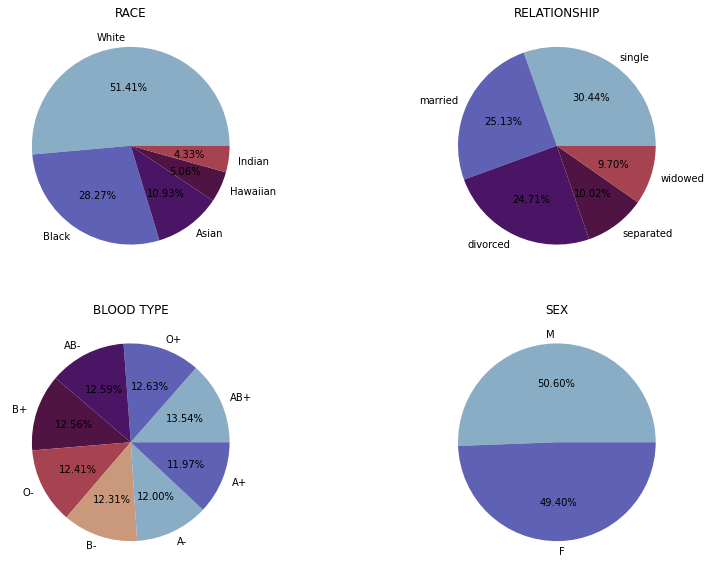

In [27]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

df_labor['relationship'].value_counts().plot(subplots=True, autopct='%.2f%%', kind='pie', ylabel = "", ax=axs[0][1])
axs[0][1].set_title('RELATIONSHIP')
df_profile['blood_group'].value_counts().plot(subplots=True, autopct='%.2f%%', kind='pie', ylabel = "", ax=axs[1][0])
axs[1][0].set_title('BLOOD TYPE')
df_profile['sex'].value_counts().plot(subplots=True, autopct='%.2f%%', kind='pie', ylabel = "", ax=axs[1][1])
axs[1][1].set_title('SEX')
df_profile['race'].value_counts().plot(subplots=True, autopct='%.2f%%', kind='pie', ylabel = "", ax=axs[0][0])
axs[0][0].set_title('RACE')

<AxesSubplot:>

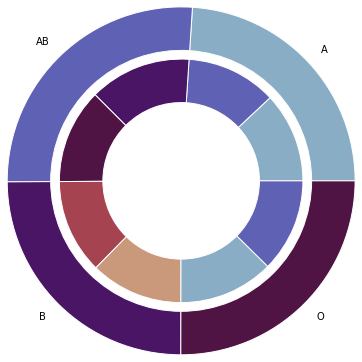

In [28]:
new_df = df_profile['blood_group'].astype(str)
new_df = new_df.replace(to_replace='[+-]', value='', regex=True)

fig, ax = plt.subplots()

df_profile['blood_group'].value_counts().sort_index().plot(kind="pie", radius=1.4, wedgeprops=dict(width=0.5, edgecolor='w'), ylabel="",labels=None)
new_df.value_counts().sort_index().plot(kind="pie", radius=2, wedgeprops=dict(width=0.5, edgecolor='w'), ylabel="")

##### Distribution of main numerical personal & laboratory attributes

- age ranges from 0 to 115 years and is almost equally distributed (should be normally distributed) - probably a random data which is not representative

- weight is slightly skewed normal distribution and values range from 0 to ~200

- erytrocyty & leukocyty have normal distribution and values range from approx. 0 to approx. 12

<AxesSubplot:xlabel='age', ylabel='Density'>

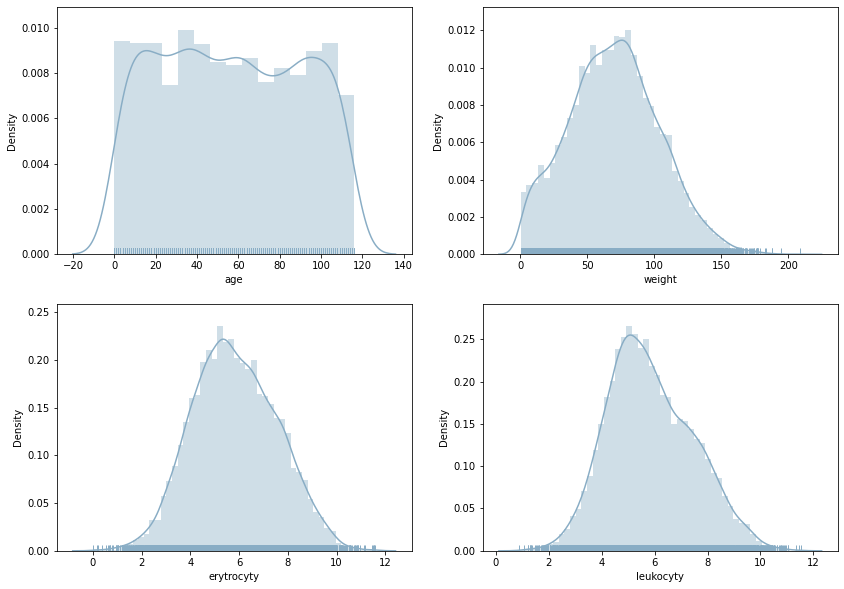

In [29]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

sns.distplot(df_labor['weight'], rug=True, ax=axs[0][1])
sns.distplot(df_labor['erytrocyty'], rug=True, ax=axs[1][0])
sns.distplot(df_labor['leukocyty'], rug=True, ax=axs[1][1])
sns.distplot(df_profile['age'], rug=True, ax=axs[0][0])

##### Distribution of all attributes

Most of the attributes have normal distribution but:
- alt has a lot of outlier values
- weight has offset
- alp doesnt have normal distribution

array([[<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'trombocyty'}>],
       [<AxesSubplot:title={'center':'hematokrit'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'alp'}>],
       [<AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>,
        <AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>],
       [<AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'birthdate'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

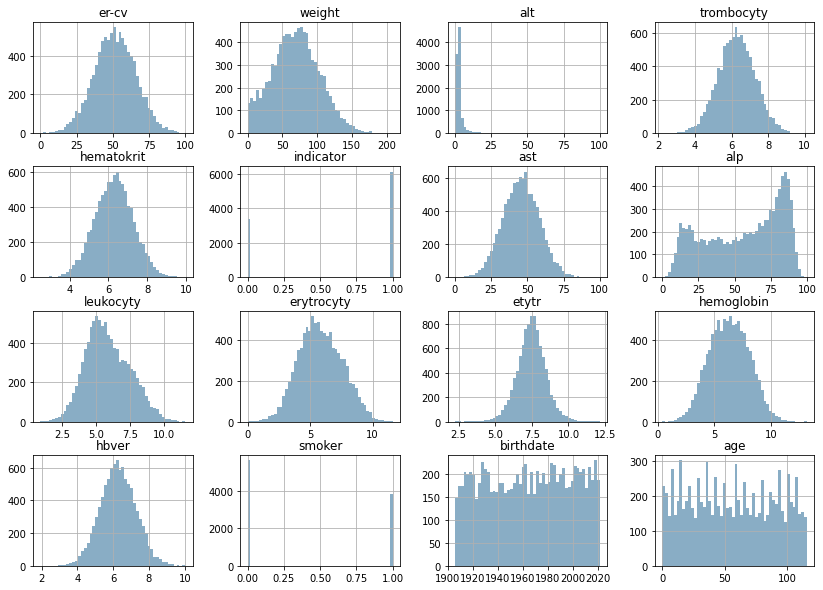

In [30]:
df_merged.hist(figsize=(14,10), bins=50)

### Pair data analysis

##### Distribution of sex in different races

- all genders are equally distributed throughout all races but white (in white there is slightly more males than females)

<AxesSubplot:xlabel='race'>

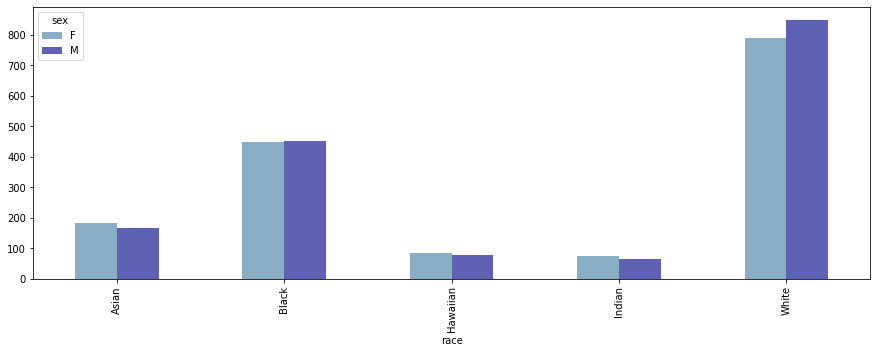

In [31]:
# Graph shows sex distribution among races
pd.crosstab(index=df_profile["race"], columns=df_profile["sex"]).plot.bar(figsize = (15,5))

##### Correlation of all attributes using the Pearson formula

Almost all values are close to 0 which means there is no linear relation between these attributes

Significant correlation is between these attributes:
- alt & erytrocyty (0.55)
- alp & etytr (-0.44)
- alt & hemoglobin (0.41)
- erytrocyty & hemoglobin (0.40)

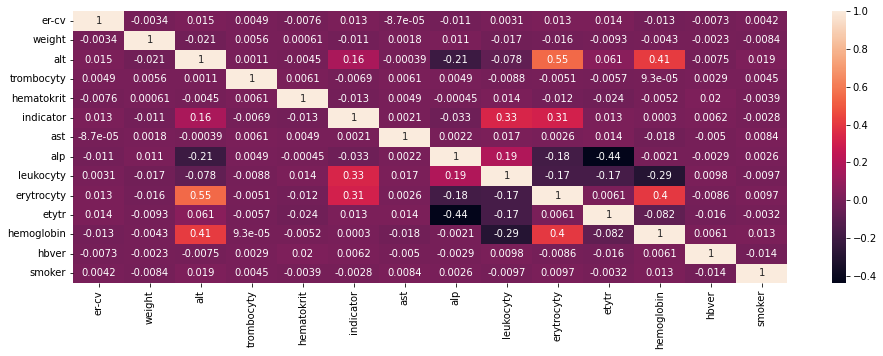

In [32]:
# Table of the correlations between all attributes
plt.figure(figsize = (16,5))
ax = sns.heatmap(df_labor.corr(method='pearson'), annot=True)

##### Relation plot of 3 main enzymes (*alt*, *alp*, *ast*)

High *alp* values (dark color) is in the area with lowest *alt* values, *ast* values seem to have no effect to the other two variables.

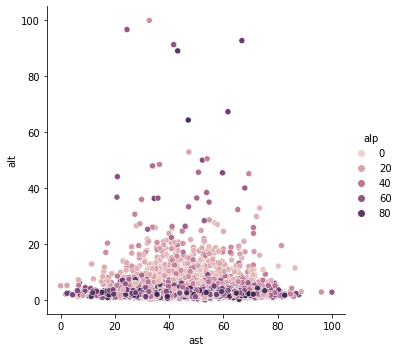

In [33]:
# Graph shows the relation between three enzymes
sns.relplot(x="ast", y="alt", hue="alp", data=df_labor)

##### Relation between erytrocyty & alt

- *alt* values rise exponentionally after meeting threshold of *erytrocyty* = 8

<AxesSubplot:xlabel='erytrocyty', ylabel='alt'>

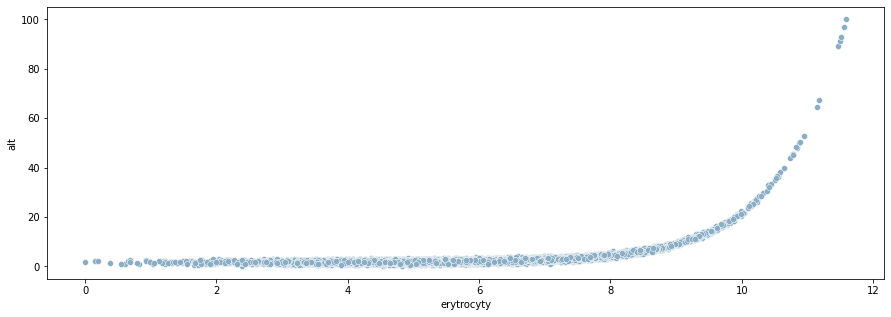

In [34]:
# Graph displays the relation between the erytrocyty & alt enzyme
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x="erytrocyty", y="alt", ax=ax, data=df_labor)

##### Relation between hemoglobin & alp

- the graph shows cosine function relationship which is really strange for these attributes, the data might be not representative

<AxesSubplot:xlabel='hemoglobin', ylabel='alp'>

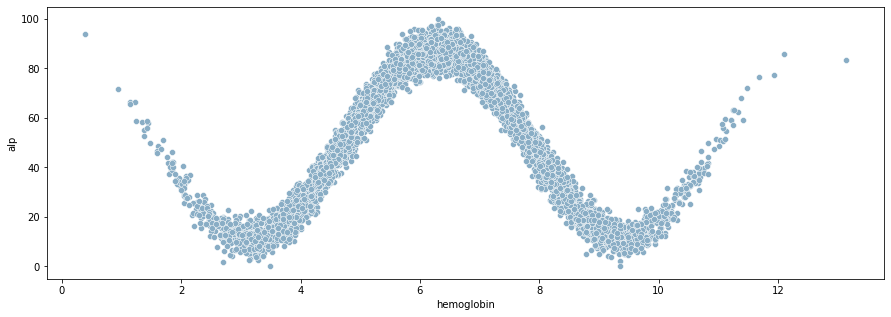

In [35]:
# Graph displays the relation between the hemoglobin & alp enzyme
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x="hemoglobin", y="alp", ax=ax, data=df_labor)

##### Correlation between predicted value (indicator) & other attributes

Highest correlation with predicted value have:
- leukocyty (0.33)
- erytrocyty (0.31)
- alt (0.16)

In [36]:
# The number shows correlation between the indicator and other attributes
# Number values closer to 1 or -1 demonstrate stronger relations between both of the attributes
df_labor.corr()['indicator'].sort_values(ascending = False)

indicator     1.000000
leukocyty     0.331936
erytrocyty    0.310355
alt           0.163859
etytr         0.013473
er-cv         0.013152
hbver         0.006207
ast           0.002104
hemoglobin    0.000305
smoker       -0.002778
trombocyty   -0.006881
weight       -0.011483
hematokrit   -0.013216
alp          -0.033249
Name: indicator, dtype: float64

##### Correlation between predicted value (indicator), erytrocyty & leukocyty

There are 2 distinct groups marked with colors:
- light blue (no health progress) - both erytrocyty & leukocyty have low values
- purple (good health progress) - erytrocyty & leukocyty have opposite values (high & low or low & high)

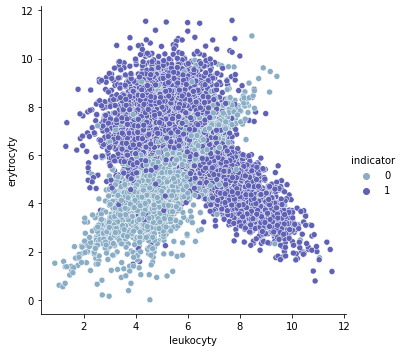

In [37]:
# Graph shows the relation between the indicator and erytrocyty
sns.relplot(x="leukocyty", y="erytrocyty", hue="indicator", data=df_labor)

##### Relation between distribution of age / weight & other attributes

age is distributed almost equally accross all other attributes so the data might be random (not representative)

weight is also distributed almost equally accross all other attributes so the data might be random (not representative)

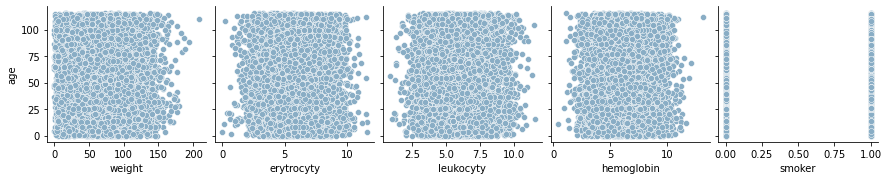

In [38]:
sns.pairplot(data=df_merged, y_vars=['age'], x_vars=['weight','erytrocyty','leukocyty','hemoglobin','smoker'])

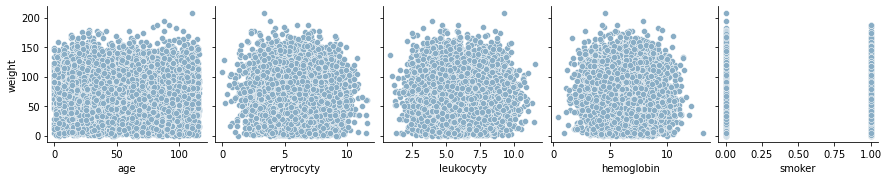

In [39]:
sns.pairplot(data=df_merged, y_vars=['weight'], x_vars=['age','erytrocyty','leukocyty','hemoglobin','smoker'])

##### Relation between chosen pairs of laboratory attributes

Darker areas show higher value density of both attributes

ValueError: Could not interpret value `Set1` for parameter `hue`

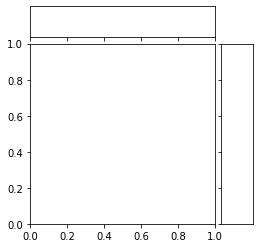

In [43]:
cols = [('alt','alp'),('etytr','alp'),('leukocyty','erytrocyty'),('hemoglobin','erytrocyty')]
for row,col in cols:
    sns.jointplot(data=df_merged, x=row, y=col, kind='kde', height=4, fill = True, hue='indicator', joint_kws={'alpha': 0.7})

##### Relation between indicator & other attributes

When the boxes are next to each other it means there is no relation between categorical values and numerical variable.

We can see the alt-indicator graph is not readable because of outliers so ww tried to remove outliers from the dataset and show the relation again. After removing the outliers the graph is readable and there might be weak relation between alt & indicator as the boxes are not next to each other.

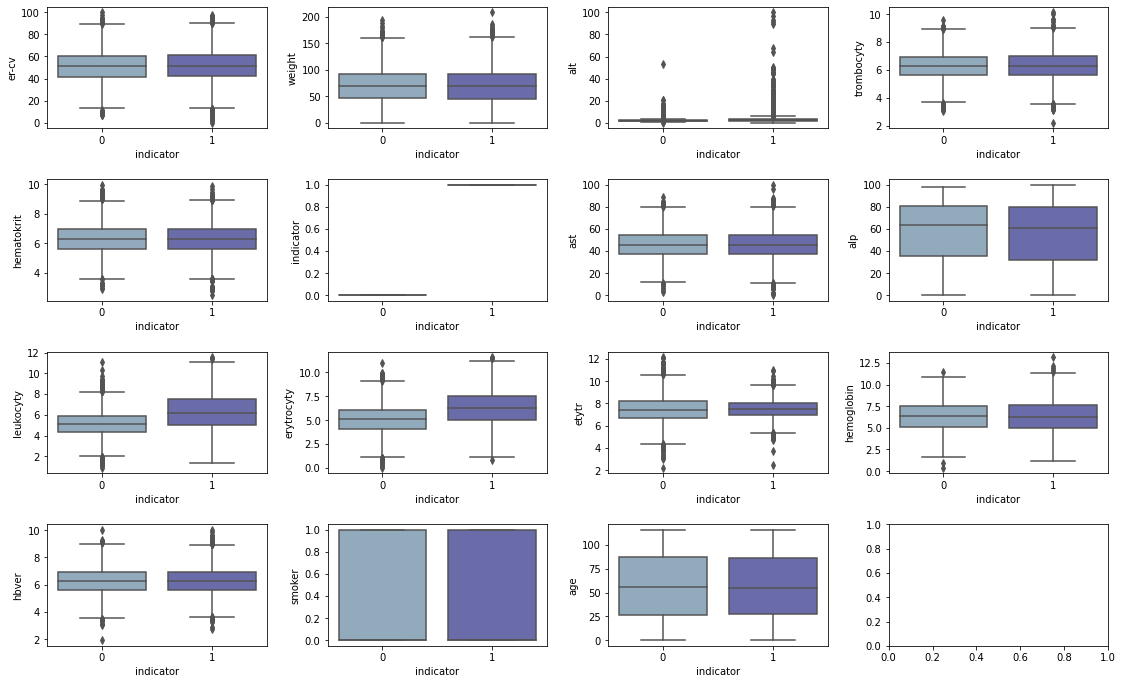

In [192]:
# Boxplots showing relation between each numerical attribute and indicator
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(16, 10)
fig.tight_layout(pad=3.0)
for index,col in enumerate(df_merged.select_dtypes(include=np.number).columns.tolist()):
    sns.boxplot(x='indicator', y=col, data=df_merged, ax=axs[index//4][index%4])

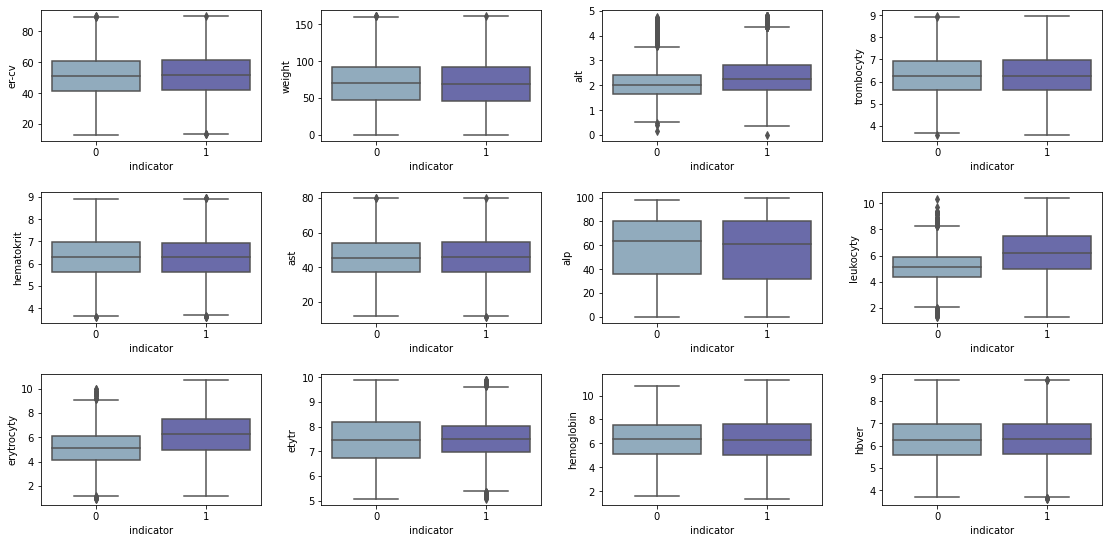

In [193]:
# Boxplots showing relation between each numerical attribute and indicator after removing the outliers
def remove_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    return a[(a < upper) & (a > lower)]

fig, axs = plt.subplots(3, 4)
fig.set_size_inches(16, 8)
fig.tight_layout(pad=3.0)
df_merged_wo = df_merged.copy()
for index,col in enumerate(df_merged.select_dtypes(include=['float']).columns.tolist()):
    df_merged_wo[col] = remove_outliers(df_merged[col])
    sns.boxplot(x='indicator', y=col, data=df_merged_wo, ax=axs[index//4][index%4])

##### Progress of each individual patient

We tried to show changes in each individual patient attributes so we looked at the number of records for each person

We found out that number of records for patients range from 1 to 4 which is extremely low

Also the data plotted from one selected patient shows no significant change in values after the health progress

In [194]:
df_merged.groupby('ssn').size().sort_values(ascending=False).value_counts()

3    2672
2     270
4     235
1       7
dtype: int64

In [195]:
person = df_merged[df_merged['ssn'] == df_merged.groupby('ssn').size().sort_values(ascending=False).index[0]]

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

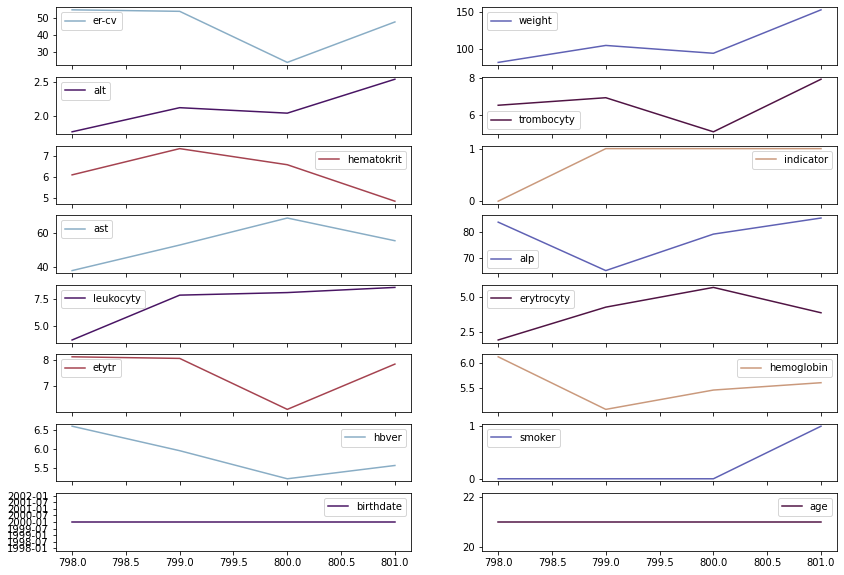

In [196]:
person.plot.line(figsize=(14,10), layout=(8,2), subplots=True)

### Formulation of hypothesis and hypothesis testing

#### H<sub>0</sub>: Average level of leukocyty is higher in patients with health progress than in patients without health progress.
#### H<sub>A</sub>: Average level of leukocyty is less or equal in patients with health progress than in patients without health progress.

First dataset = Patients with health progress (indicator = 1)
Second dataset = Patients without health progress (indicator = 0)

Assumptions:
- Both datasets are normally distributed (Check with Shapiro–Wilk test)
- Both dataset have similar variance (Check with Levene's test)

If we confirm all assumptions we can do T-test to reject or not reject null hypothesis.

In [197]:
h1_data1 = df_merged[df_merged['indicator'] == 1]['leukocyty']
h1_data2 = df_merged[df_merged['indicator'] == 0]['leukocyty']

In [198]:
s1, p1 = stats.shapiro(h1_data1)
s2, p2 = stats.shapiro(h1_data2)
print(f"Data1: s={s1}, p={p1}, data is {'not' if p1<0.05 else ''} normally distributed")
print(f"Data2: s={s2}, p={p2}, data is {'not' if p2<0.05 else ''} normally distributed")

Data1: s=0.9931604862213135, p=1.451379440766117e-16, data is not normally distributed
Data2: s=0.9965821504592896, p=5.676093906004098e-07, data is not normally distributed


##### Both datasets don't come from normal distribution, therefore we can not use the T-test, we'll use U-test instead.

<AxesSubplot:xlabel='leukocyty', ylabel='Count'>

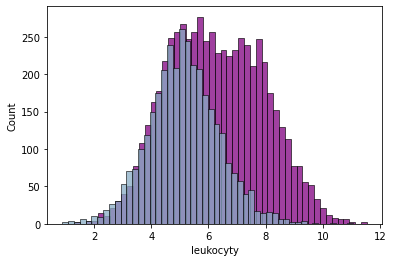

In [199]:
sns.histplot(h1_data1, bins=50, color='purple')
sns.histplot(h1_data2, bins=50)

In [200]:
s, p = stats.mannwhitneyu(h1_data1, h1_data2, alternative='less')
print(f"U-test: s={s}, p={p}, H0 is {'not ' if p>=0.05 else ''}rejected")

U-test: s=14436987.0, p=1.0, H0 is not rejected


##### We performed U-test with setting alternative hypothesis to 'less'
**The test failed to reject H<sub>0</sub> as p-value was larger than 0.05**

___
#### H<sub>0</sub>: Average level of alt is equal in both patients with health progress and without health progress.
#### H<sub>A</sub>: Average level of alt is equal in both patients with health progress and without health progress.

First dataset = Patients with health progress (indicator = 1)
Second dataset = Patients without health progress (indicator = 0)

Assumptions:
- Both datasets are normally distributed (Check with Shapiro–Wilk test)
- Both dataset have similar variance (Check with Levene's test)

If we confirm all assumptions we can do T-test to reject or not reject null hypothesis.

In [201]:
h2_data1 = df_merged[df_merged['indicator'] == 1]['alt']
h2_data2 = df_merged[df_merged['indicator'] == 0]['alt']

In [202]:
s1, p1 = stats.shapiro(h2_data1)
s2, p2 = stats.shapiro(h2_data2)
print(f"Data1: s={s1}, p={p1}, data is {'not' if p1<0.05 else ''} normally distributed")
print(f"Data2: s={s2}, p={p2}, data is {'not' if p2<0.05 else ''} normally distributed")

Data1: s=0.39044809341430664, p=0.0, data is not normally distributed
Data2: s=0.4225996732711792, p=0.0, data is not normally distributed


##### Both datasets don't come from normal distribution, therefore we can not use the T-test, we'll use U-test instead.

<AxesSubplot:xlabel='alt', ylabel='Count'>

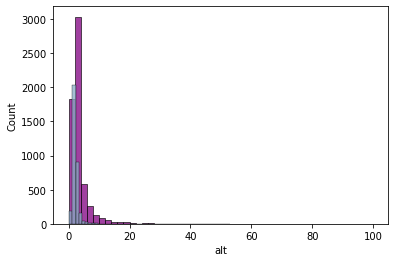

In [203]:
sns.histplot(h2_data1, bins=50, color='purple')
sns.histplot(h2_data2, bins=50)

In [204]:
s, p = stats.mannwhitneyu(h2_data1, h2_data2)
print(f"U-test: s={s}, p={p}, H0 is {'not ' if p>=0.05 else ''}rejected")

U-test: s=13560411.5, p=2.4276492892773124e-137, H0 is rejected


##### We performed U-test
**The test rejected H<sub>0</sub> as p-value was less than 0.05, therefore there is significant statistical difference between the two data samples.**